In [1]:
# =============================
# CELL 1 — Imports & Settings
# =============================
import os
import glob
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Paths
CLIENTS_OUT = "processed/clients"

# Reproducible-ish
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)
print("Client files:", sorted(glob.glob(os.path.join(CLIENTS_OUT, "client_*.npz"))))


TF version: 2.10.0
Client files: ['processed/clients\\client_0.npz', 'processed/clients\\client_1.npz', 'processed/clients\\client_2.npz', 'processed/clients\\client_3.npz', 'processed/clients\\client_4.npz', 'processed/clients\\client_5.npz', 'processed/clients\\client_6.npz', 'processed/clients\\client_7.npz', 'processed/clients\\client_8.npz']


In [2]:
# =============================
# CELL 2 — Model (BatchNorm + small LR)
# =============================
from tensorflow.keras import layers, models

def build_video_encoder(input_shape=(48,48,1), emb_dim=64):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, padding='same', kernel_initializer="he_normal")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(32, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(emb_dim, activation='relu', kernel_initializer="he_normal")(x)
    return models.Model(inp, x, name="video_encoder")

def build_audio_encoder(input_shape=(1,40), emb_dim=32):
    inp = layers.Input(shape=input_shape)
    x = layers.Flatten()(inp)
    x = layers.Dense(128, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(emb_dim, activation='relu', kernel_initializer="he_normal")(x)
    return models.Model(inp, x, name="audio_encoder")

def build_ecg_encoder(input_shape=(128,), emb_dim=32):
    inp = layers.Input(shape=input_shape)
    x = layers.Reshape((128,1))(inp)
    x = layers.Conv1D(16, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool1D()(x)

    x = layers.Conv1D(32, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(emb_dim, activation='relu', kernel_initializer="he_normal")(x)
    return models.Model(inp, x, name="ecg_encoder")

def build_fusion_model():
    v_in = layers.Input(shape=(48,48,1), name="video_input")
    a_in = layers.Input(shape=(1,40), name="audio_input")
    e_in = layers.Input(shape=(128,), name="ecg_input")

    v = build_video_encoder()(v_in)
    a = build_audio_encoder()(a_in)
    e = build_ecg_encoder()(e_in)

    x = layers.Concatenate()([v, a, e])
    x = layers.Dense(128, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    out = layers.Dense(1, activation='sigmoid', name="output")(x)

    model = models.Model([v_in, a_in, e_in], out)
    # Lower learning rate for stability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# build a quick instance and print summary
model = build_fusion_model()
model.summary(expand_nested=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_input (InputLayer)       [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 audio_input (InputLayer)       [(None, 1, 40)]      0           []                               
                                                                                                  
 ecg_input (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 video_encoder (Functional)     (None, 64)           27904       ['video_input[0][0]']            
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [3]:
# =============================
# CELL 3 — Load client data function
# =============================
import numpy as np

def load_client_npz(client_npz_path: str):
    """Load client_x.npz and flatten sessions into per-frame arrays."""
    d = np.load(client_npz_path, allow_pickle=True)
    frames_list = d["frames"]   # object array: each session -> (T,H,W,1)
    mfcc_list   = d["mfcc"]     # object array: each session -> (T,40)
    ecg_list    = d["ecg"]      # object array: each session -> (T,128)
    labels      = d["labels"]   # array: one label per session

    Xv, Xa, Xe, y = [], [], [], []

    for i in range(len(frames_list)):
        fr = frames_list[i]
        mf = mfcc_list[i]
        ec = ecg_list[i]
        lab = int(labels[i])
        if fr.shape[0] == 0:
            continue
        for t in range(fr.shape[0]):
            Xv.append(fr[t])
            # MFCC may be shorter; safe indexing
            if t < mf.shape[0]:
                Xa.append(np.expand_dims(mf[t], axis=0))
            else:
                Xa.append(np.zeros((1,40), dtype=np.float32))
            if t < ec.shape[0]:
                Xe.append(ec[t])
            else:
                Xe.append(np.zeros((128,), dtype=np.float32))
            y.append(lab)

    if len(y) == 0:
        return None

    Xv = np.array(Xv, dtype=np.float32)
    Xa = np.array(Xa, dtype=np.float32)
    Xe = np.array(Xe, dtype=np.float32)
    y  = np.array(y, dtype=np.float32)

    print(f"Loaded {client_npz_path}: {len(y)} samples")
    return Xv, Xa, Xe, y

# quick check
client_files = sorted(glob.glob(os.path.join(CLIENTS_OUT, "client_*.npz")))
print("Clients:", client_files)
if client_files:
    sample = load_client_npz(client_files[0])
    if sample:
        Xv_s, Xa_s, Xe_s, y_s = sample
        print("Shapes:", Xv_s.shape, Xa_s.shape, Xe_s.shape, y_s.shape)


Clients: ['processed/clients\\client_0.npz', 'processed/clients\\client_1.npz', 'processed/clients\\client_2.npz', 'processed/clients\\client_3.npz', 'processed/clients\\client_4.npz', 'processed/clients\\client_5.npz', 'processed/clients\\client_6.npz', 'processed/clients\\client_7.npz', 'processed/clients\\client_8.npz']
Loaded processed/clients\client_0.npz: 33532 samples
Shapes: (33532, 48, 48, 1) (33532, 1, 40) (33532, 128) (33532,)


In [5]:
# =============================
# CELL 4 — Generators & utilities
# =============================
import gc

def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

def data_generator(Xv, Xa, Xe, y, batch_size=16):
    n = len(y)
    idx = np.arange(n)
    while True:
        np.random.shuffle(idx)
        for i in range(0, n, batch_size):
            b = idx[i:i+batch_size]
            yield ([Xv[b], Xa[b], Xe[b]], y[b])

def eval_generator(Xv, Xa, Xe, y, batch_size=32):
    n = len(y)
    for i in range(0, n, batch_size):
        b = slice(i, i+batch_size)
        yield ([Xv[b], Xa[b], Xe[b]], y[b])


In [6]:
# =============================
# CELL 5 — Warmup: server pretrain
# =============================
# Use a random subset from client 0 to initialize global weights
client_files = sorted(glob.glob(os.path.join(CLIENTS_OUT, "client_*.npz")))
assert len(client_files) > 0, "No client files found."

print("Warmup: sampling from", client_files[0])
warmup_data = load_client_npz(client_files[0])
if warmup_data is None:
    raise RuntimeError("Client 0 has no data to warmup.")

Xv_all, Xa_all, Xe_all, y_all = warmup_data

# sample size and epochs tuned for warmup
WARMUP_SAMPLES = min(500, len(y_all))
WARMUP_EPOCHS = 3
BATCH_SIZE = 32

idx_w = np.random.choice(len(y_all), WARMUP_SAMPLES, replace=False)
Xv_w = Xv_all[idx_w]
Xa_w = Xa_all[idx_w]
Xe_w = Xe_all[idx_w]
y_w  = y_all[idx_w]

warmup_model = build_fusion_model()
print(f"Warmup training: {WARMUP_SAMPLES} samples, {WARMUP_EPOCHS} epochs")
warmup_model.fit([Xv_w, Xa_w, Xe_w], y_w, epochs=WARMUP_EPOCHS, batch_size=BATCH_SIZE, verbose=1)

global_weights = warmup_model.get_weights()

# free warmup memory
del warmup_model, Xv_all, Xa_all, Xe_all, y_all, Xv_w, Xa_w, Xe_w, y_w
clear_memory()
print("Warmup complete — global weights initialized.")


Warmup: sampling from processed/clients\client_0.npz
Loaded processed/clients\client_0.npz: 33532 samples
Warmup training: 500 samples, 3 epochs
Epoch 1/3
16/16 [==============================] - 5s 23ms/step - loss: 0.6895 - accuracy: 0.6640
Epoch 2/3
16/16 [==============================] - 0s 12ms/step - loss: 0.6411 - accuracy: 0.6760
Epoch 3/3
16/16 [==============================] - 0s 14ms/step - loss: 0.5798 - accuracy: 0.7080
Warmup complete — global weights initialized.


In [7]:
# =============================
# CELL 6 — Low-memory FL loop + metrics
# =============================
NUM_ROUNDS = 5
BATCH_TRAIN = 16
BATCH_EVAL = 32

client_files = sorted(glob.glob(os.path.join(CLIENTS_OUT, "client_*.npz")))
print("Running FL on clients:", client_files)

# initialize global model with warmup weights
global_model = build_fusion_model()
global_model.set_weights(global_weights)

round_acc = []
round_loss = []

for rnd in range(NUM_ROUNDS):
    print(f"\n===== ROUND {rnd+1}/{NUM_ROUNDS} =====")
    aggregated = []
    counts = []

    for cid, path in enumerate(client_files):
        print(f" Client {cid}: loading {path} ...")
        data = load_client_npz(path)
        if data is None:
            print("  Skipping empty client", cid)
            continue
        Xv, Xa, Xe, y = data

        # local training model
        local_model = build_fusion_model()
        local_model.set_weights(global_model.get_weights())

        steps = max(1, len(y) // BATCH_TRAIN)
        gen = data_generator(Xv, Xa, Xe, y, batch_size=BATCH_TRAIN)
        local_model.fit(gen, steps_per_epoch=steps, epochs=1, verbose=0)

        new_weights = local_model.get_weights()
        aggregated.append((new_weights, len(y)))
        counts.append(len(y))

        # clear client memory explicitly
        del local_model, Xv, Xa, Xe, y, gen
        clear_memory()
        print(f"  Client {cid} finished (samples={counts[-1]})")

    # FedAvg aggregation
    total = sum(counts)
    if total == 0:
        raise RuntimeError("No samples found across clients.")
    new_global = []
    current_global = global_model.get_weights()
    for layer_idx in range(len(current_global)):
        # weighted average
        layer_avg = sum(w[layer_idx] * n for (w, n) in aggregated) / total
        new_global.append(layer_avg)

    global_model.set_weights(new_global)

    # Evaluate global_model on client 0 (GPU-safe)
    print(" Evaluating global model (client 0)...")
    eval_data = load_client_npz(client_files[0])
    Xv_e, Xa_e, Xe_e, y_e = eval_data
    eval_steps = max(1, len(y_e) // BATCH_EVAL)
    loss, acc = global_model.evaluate(eval_generator(Xv_e, Xa_e, Xe_e, y_e, batch_size=BATCH_EVAL),
                                      steps=eval_steps, verbose=0)
    round_loss.append(float(loss))
    round_acc.append(float(acc))
    print(f" Round {rnd+1} → loss: {loss:.4f}, acc: {acc:.4f}")

    # free eval data and clear memory
    del Xv_e, Xa_e, Xe_e, y_e
    clear_memory()

print("\nFederated training finished.")


Running FL on clients: ['processed/clients\\client_0.npz', 'processed/clients\\client_1.npz', 'processed/clients\\client_2.npz', 'processed/clients\\client_3.npz', 'processed/clients\\client_4.npz', 'processed/clients\\client_5.npz', 'processed/clients\\client_6.npz', 'processed/clients\\client_7.npz', 'processed/clients\\client_8.npz']

===== ROUND 1/5 =====
 Client 0: loading processed/clients\client_0.npz ...
Loaded processed/clients\client_0.npz: 33532 samples
  Client 0 finished (samples=33532)
 Client 1: loading processed/clients\client_1.npz ...
Loaded processed/clients\client_1.npz: 32470 samples
  Client 1 finished (samples=32470)
 Client 2: loading processed/clients\client_2.npz ...
Loaded processed/clients\client_2.npz: 33060 samples
  Client 2 finished (samples=33060)
 Client 3: loading processed/clients\client_3.npz ...
Loaded processed/clients\client_3.npz: 33060 samples
  Client 3 finished (samples=33060)
 Client 4: loading processed/clients\client_4.npz ...
Loaded proce

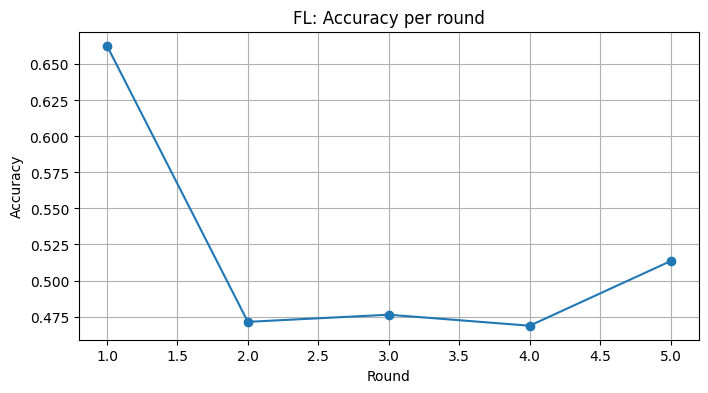

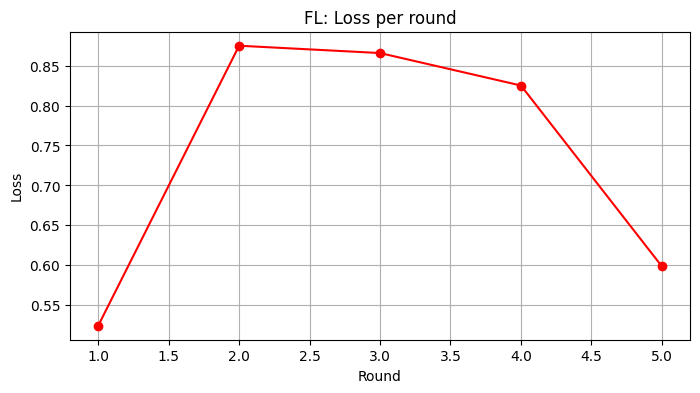

In [9]:
# =============================
# CELL 7 — Plot Accuracy & Loss
# =============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(1, len(round_acc)+1), round_acc, marker='o')
plt.title("FL: Accuracy per round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(1, len(round_loss)+1), round_loss, marker='o', color='red')
plt.title("FL: Loss per round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [10]:
# =============================
# CELL 8 — Save & Final Eval / Demo predict
# =============================
SAVE_PATH = "global_model_hyper_warmup.h5"
global_model.save(SAVE_PATH)
print("Saved global model to:", SAVE_PATH)

# final evaluate (GPU-safe) on client 0
eval_data = load_client_npz(client_files[0])
Xv_f, Xa_f, Xe_f, y_f = eval_data
steps = max(1, len(y_f) // 32)
loss, acc = global_model.evaluate(eval_generator(Xv_f, Xa_f, Xe_f, y_f, batch_size=32), steps=steps, verbose=0)
print("Final eval on client 0 → loss:", loss, "acc:", acc)
del Xv_f, Xa_f, Xe_f, y_f
clear_memory()

# demo predictions on first 10 samples of client 0 (if available)
demo_data = load_client_npz(client_files[0])
if demo_data:
    Xv_d, Xa_d, Xe_d, y_d = demo_data
    n_demo = min(10, len(y_d))
    preds = global_model.predict([Xv_d[:n_demo], Xa_d[:n_demo], Xe_d[:n_demo]])
    print("Demo preds (probabilities):", preds.flatten())
    del Xv_d, Xa_d, Xe_d, y_d
    clear_memory()


Saved global model to: global_model_hyper_warmup.h5
Loaded processed/clients\client_0.npz: 33532 samples
Final eval on client 0 → loss: 0.5987274646759033 acc: 0.5134909152984619
Loaded processed/clients\client_0.npz: 33532 samples
1/1 [==============================] - 0s 62ms/step
Demo preds (probabilities): [0.00071362 0.00259526 0.00114699 0.00192086 0.00031912 0.00021991
 0.00014637 0.00015241 0.00043042 0.00065817]
